# Validation on simulated data set
* use bead stack that was created for the PSF calibration
* run fitter on test bead stack  

In [1]:
import os
root=r"F:\moritz\babcock_test\8plane"
os.chdir(root)
print(os.getcwd())

F:\moritz\babcock_test\8plane


### helpers

In [2]:
# helpers 
import storm_analysis.sa_library.sa_h5py as saH5Py
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import pickle
from tkinter import filedialog
from tkinter import *
import json
from tqdm import tqdm
import csv
from natsort import natsorted

def hdf5PxlToTxtNm(hdf5_name, txt_name, pixel_size):
    locfields = ['x', 'y', 'z']
    nmfields = [f+"nm" for f in locfields]
    with saH5Py.SAH5Reader(hdf5_name) as h5:
        nm_per_pixel = h5.getPixelSize()
        [movie_x, movie_y, movie_l, hash_value] = h5.getMovieInformation()

        with open(txt_name, "w") as fp:
            has_header = False
            fields = None
            
            # Convert tracks.
            if h5.hasTracks():
                index = 0
                print("Converting tracks.")
                for tracks in tqdm(h5.tracksIterator()):
                    
                    if not has_header:
                        fields = sorted(tracks.keys())
                        fp.write(",".join(["index"] + fields + nmfields) + "\n")
                        has_header = True

                    for i in range(tracks["x"].size):
                        text = [str(index)]
                        cc = {}
                        for field in fields:
                            if(tracks[field].dtype == np.int32):
                                text.append(str(tracks[field][i]))
                            else:
                                text.append("{0:.3f}".format(tracks[field][i]))

                            if field in locfields:
                                cc[field] = tracks[field][i]

                        for k in cc.keys():
                            if(tracks[k].dtype == np.int32):
                                text.append(str(tracks[k][i]*pixel_size))
                            else:
                                text.append("{0:.3f}".format(tracks[k][i]*pixel_size))


                        fp.write(",".join(text) + "\n")
                        index += 1
                        
            # Convert localizations.
            else:
                index = 0
                print("Converting localizations.")
                for fnum, locs in tqdm(h5.localizationsIterator(drift_corrected = False)):
                                        
                    if not has_header:
                        fields = sorted(locs.keys())
                        fp.write(",".join(["index", "frame"] + fields + nmfields) + "\n")
                        has_header = True

                    for i in range(locs["x"].size):
                        text = [str(index),str(fnum)]
                        cc={}
                        for field in fields:
                            if(locs[field].dtype == np.int32):
                                text.append(str(locs[field][i]))
                            else:
                                text.append("{0:.3f}".format(locs[field][i]))

                            if field in locfields:
                                cc[field] = locs[field][i]

                        for k in cc.keys():
                            if(locs[k].dtype == np.int32):
                                text.append(str(locs[k][i]*pixel_size))
                            else:
                                text.append("{0:.3f}".format(locs[k][i]*pixel_size))
                                
                        fp.write(",".join(text) + "\n")
                        index += 1


## check if prerequisite are met

In [3]:
if not os.path.exists("weights.npy"):
    print("Please run the multiplane_psfs_to_spline notebook first")

if not os.path.exists("multiplane.xml"):
    print("Please run the multiplane_psfs_to_spline notebook first")


In [4]:
basename = os.path.join(r"validation", "_") 
mlist_name = os.path.join(r"validation", r'_validation_highcutoff.hdf5') 

In [6]:
import storm_analysis.multi_plane.multi_plane as mp
mp.analyze(basename, mlist_name, 'multiplane.xml')

KeyError: '2_0_x'

In [41]:
import storm_analysis.sa_utilities.hdf5_to_txt as txt_conv
txtname = mlist_name.replace('.hdf5', '.txt')
txt_conv.hdf5ToTxt(mlist_name, txtname)

Converting localizations.


In [42]:
pixel_size = 100 # nm

In [43]:
# convert localisation coordinates from pixel to nm
txtname = mlist_name.replace('.hdf5', '_pxl2nm.txt')
print(f"Writing to {txtname}")
hdf5PxlToTxtNm(mlist_name, txtname, pixel_size)

Writing to validation\_validation_highcutoff_pxl2nm.txt
Converting localizations.


151it [00:00, 232.65it/s]


Tracks not found, using localizations.
.


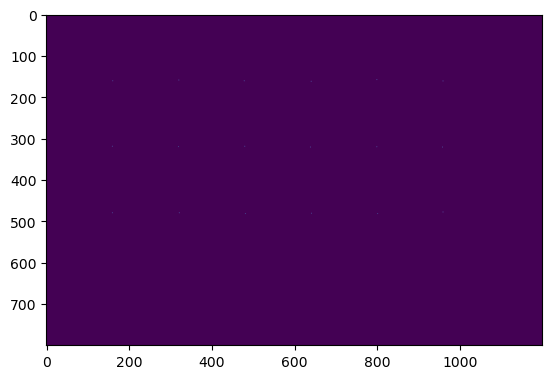

In [44]:
import storm_analysis.sa_utilities.hdf5_to_image as img_conv

tiffname = mlist_name.replace('.hdf5', '.tiff')
img2d = img_conv.render2DImage(mlist_name, scale = 4)
plt.imshow(img2d)

Tracks not found, using localizations.
.


(200, 300)

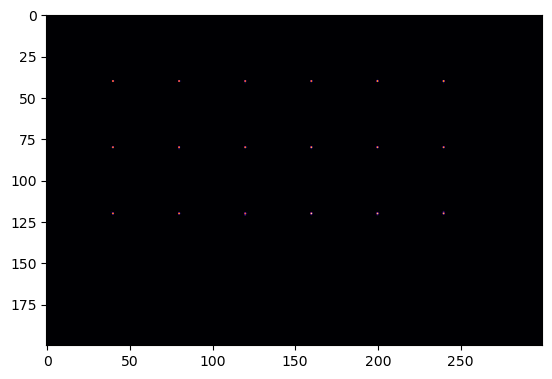

In [45]:
img3d = img_conv.render3DImage(mlist_name, z_edges= [-0.1, 0.1] , scale = 1)
plt.imshow(img3d[0], cmap='inferno')
img3d[0].shape